In [1]:
import pandas as pd
import json
import ast
import pickle
import geopandas as gpd
from functools import reduce
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import os
import numpy as np
from scipy.stats import poisson
from scipy.stats import norm
import statsmodels.api as sms
import statsmodels.formula.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

/Users/liqingchun/opt/anaconda3/envs/Ida/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
core = pd.read_csv("./Louisiana state core/LA.csv.gz")

In [40]:
new_08_02 = pd.read_csv('./weekly_data/08_02/LA_08_02.csv.gz')

new_08_09 = pd.read_csv('./weekly_data/08_09/LA_08_09.csv.gz')

new_08_16 = pd.read_csv('./weekly_data/08_16/LA_08_16.csv.gz')

new_08_23 = pd.read_csv('./weekly_data/08_23/LA_08_23.csv.gz')

## get number of residing devices in cbgs

In [4]:
de_0802 = pd.read_csv('./weekly_data/08_02/safegraph_home_panel_summary.csv.gz')

de_0802 = de_0802[de_0802.region=='la'][['census_block_group', 'number_devices_residing']].reset_index(drop=True)

de_0802 = de_0802.rename(columns={'census_block_group':'GEOID'})

de_0802.GEOID = de_0802.GEOID.astype(int)

In [5]:
de_0809 = pd.read_csv('./weekly_data/08_09/safegraph_home_panel_summary.csv.gz')

de_0809 = de_0809[de_0809.region=='la'][['census_block_group', 'number_devices_residing']].reset_index(drop=True)

de_0809 = de_0809.rename(columns={'census_block_group':'GEOID'})

de_0809.GEOID = de_0809.GEOID.astype(int)

In [6]:
de_0816 = pd.read_csv('./weekly_data/08_16/safegraph_home_panel_summary.csv.gz')

de_0816 = de_0816[de_0816.region=='la'][['census_block_group', 'number_devices_residing']].reset_index(drop=True)

de_0816 = de_0816.rename(columns={'census_block_group':'GEOID'})

de_0816.GEOID = de_0816.GEOID.astype(int)

In [7]:
de_0823 = pd.read_csv('./weekly_data/08_23/safegraph_home_panel_summary.csv.gz')

de_0823 = de_0823[de_0823.region=='la'][['census_block_group', 'number_devices_residing']].reset_index(drop=True)

de_0823 = de_0823.rename(columns={'census_block_group':'GEOID'})

de_0823.GEOID = de_0823.GEOID.astype(int)

In [8]:
new_08_02 = new_08_02.merge(core, how='left', on='placekey')
build_new_08_02 = new_08_02[new_08_02.sg_c__top_category == 'Building Material and Supplies Dealers']
build_new_08_02 = build_new_08_02.rename(columns={"sg_wp__visitor_home_cbgs": "visitor_home_cbgs"})

In [9]:
new_08_09 = new_08_09.merge(core, how='left', on='placekey')
build_new_08_09 = new_08_09[new_08_09.sg_c__top_category == 'Building Material and Supplies Dealers']
build_new_08_09 = build_new_08_09.rename(columns={"sg_wp__visitor_home_cbgs": "visitor_home_cbgs"})

In [10]:
new_08_16 = new_08_16.merge(core, how='left', on='placekey')
build_new_08_16 = new_08_16[new_08_16.sg_c__top_category == 'Building Material and Supplies Dealers']
build_new_08_16 = build_new_08_16.rename(columns={"sg_wp__visitor_home_cbgs": "visitor_home_cbgs"})

In [41]:
new_08_23 = new_08_23.merge(core, how='left', on='placekey')
build_new_08_23 = new_08_23[new_08_23.sg_c__top_category == 'Building Material and Supplies Dealers']
build_new_08_23 = build_new_08_23.rename(columns={"sg_wp__visitor_home_cbgs": "visitor_home_cbgs"})

In [12]:
def Cbg_visit(dataframe):
    cbg_visit = {}
    for each in dataframe.visitor_home_cbgs:
        poi_visit = ast.literal_eval(each)
        for key, value in poi_visit.items():
            if key not in cbg_visit.keys():
                cbg_visit[key] = value
            elif key in cbg_visit.keys():
                cbg_visit[key] += value
    return cbg_visit

# Cbg geoinformation

In [13]:
cbg_shp = gpd.read_file("./tl_2019_22_bg/tl_2019_22_bg.shp")
cbg_shp['GEOID']=cbg_shp['GEOID'].astype(int)

# Demographic information (all cbgs in US)

In [14]:
cbg_pop = pd.read_csv('./cbg_2019/data/cbg_b01.csv')
cbg_pop = cbg_pop[['B01001e1', 'census_block_group']]

cbg_house = pd.read_csv('./cbg_2019/data/cbg_b11.csv')
cbg_house = cbg_house[['B11005e1', 'census_block_group']]


cbg_race = pd.read_csv('./cbg_2019/data/cbg_b02.csv')

cbg_race_white = cbg_race[['B02001e2', 'census_block_group']]
cbg_race_black = cbg_race[['B02001e3', 'census_block_group']]

cbg_income = pd.read_csv('./cbg_2019/data/cbg_b19.csv')
cbg_income_median = cbg_income[['B19013e1', 'census_block_group']]


data_frames = [cbg_pop, cbg_race_white, cbg_race_black, cbg_income_median, cbg_house]

cbg_data = reduce(lambda  left,right: pd.merge(left,right,on=['census_block_group'],
                                            how='outer'), data_frames)

cbg_data.rename(columns={"census_block_group": "GEOID", 'B01001e1':'Population', 'B02001e2':'White',
                        'B02001e3':'Black', 'B19013e1':'income_median', 'B11005e1':'households'}, inplace=True)

# Return dataframe

In [15]:
def Cor_analysis(dataframe, de_dataframe):
    visit = Cbg_visit(dataframe) #calculate cbg visits to all pois in that categories and visits to 
    #significant POIs
    visit_list = [] #visits to all pois in the category
    for each in cbg_shp['GEOID']:
        if str(each) in visit.keys():
            visit_list.append(visit[str(each)])
        else:
            visit_list.append(0)
            

    #construct new dataframe 
    df_function = cbg_shp.copy(deep=True)
    df_function['visits'] = visit_list
    
    df_temp = df_function[['GEOID', 'visits']]
    
    #concate with social demographic dataframe
    cbg_data_la = pd.merge(df_temp, cbg_data, how='left', on=['GEOID'])
    
    ##concate with device residing dataframe
    cbg_data_la = cbg_data_la.merge(de_dataframe, how='left', on=['GEOID'])
    
    
    columns = list(cbg_data_la.columns) 
    remove_list = ['GEOID', 'visits', 'number_devices_residing']
    subset = [element for element in columns if element not in remove_list]
    #print(subset)
    
    cbg_data_la = cbg_data_la.dropna(how='any', subset=subset).fillna(0)
    
    
    return cbg_data_la

In [43]:
df_08_23 = Cor_analysis(build_new_08_23, de_0823)

In [44]:
df_08_02 = Cor_analysis(build_new_08_02, de_0802)
df_08_09 = Cor_analysis(build_new_08_09, de_0809)
df_08_16 = Cor_analysis(build_new_08_16, de_0816)

In [45]:
visits_average = (df_08_02.visits + df_08_09.visits+ df_08_16.visits)/3

In [46]:
resident_average = (df_08_02.number_devices_residing + 
                    df_08_09.number_devices_residing+ 
                    df_08_16.number_devices_residing)/3

In [47]:
df_before = df_08_02.copy(deep=True)

In [48]:
df_before.visits = visits_average
df_before.number_devices_residing = resident_average

In [49]:
df_before

,GEOID,visits,Population,White,Black,income_median,households,number_devices_residing
0,221090012021,10.000000,950,858,9,52361.0,305,77.000000
1,221090012023,25.333333,950,822,0,49904.0,346,88.666667
2,221030413003,13.333333,1568,1420,148,72083.0,769,83.000000
3,221030407011,45.666667,2946,2715,109,53894.0,1176,238.333333
4,221030411011,46.666667,3721,2987,642,71655.0,1251,212.333333
...,...,...,...,...,...,...,...,...
3466,220070506003,17.000000,1937,1727,62,23867.0,630,130.666667
3467,220070501002,12.000000,1877,916,943,41375.0,770,98.333333
3468,220070503001,13.333333,1406,765,641,59848.0,554,79.666667
3469,220070506002,1.333333,1177,974,192,51552.0,474,59.333333


In [50]:
df_08_23

,GEOID,visits,Population,White,Black,income_median,households,number_devices_residing
0,221090012021,8,950,858,9,52361.0,305,89.0
1,221090012023,17,950,822,0,49904.0,346,94.0
2,221030413003,23,1568,1420,148,72083.0,769,90.0
3,221030407011,42,2946,2715,109,53894.0,1176,247.0
4,221030411011,56,3721,2987,642,71655.0,1251,216.0
...,...,...,...,...,...,...,...,...
3466,220070506003,25,1937,1727,62,23867.0,630,143.0
3467,220070501002,28,1877,916,943,41375.0,770,100.0
3468,220070503001,10,1406,765,641,59848.0,554,82.0
3469,220070506002,0,1177,974,192,51552.0,474,59.0


In [51]:
df_ratio = df_08_23.rename(columns = {'visits':'visits_after'})

df_ratio = df_ratio.merge(df_before[['GEOID', 'visits']], how='left', on='GEOID')
df_ratio['ratio'] = df_ratio.visits_after/df_ratio.visits

In [52]:
df_ratio

,GEOID,visits_after,Population,White,Black,income_median,households,number_devices_residing,visits,ratio
0,221090012021,8,950,858,9,52361.0,305,89.0,10.000000,0.800000
1,221090012023,17,950,822,0,49904.0,346,94.0,25.333333,0.671053
2,221030413003,23,1568,1420,148,72083.0,769,90.0,13.333333,1.725000
3,221030407011,42,2946,2715,109,53894.0,1176,247.0,45.666667,0.919708
4,221030411011,56,3721,2987,642,71655.0,1251,216.0,46.666667,1.200000
...,...,...,...,...,...,...,...,...,...,...
3216,220070506003,25,1937,1727,62,23867.0,630,143.0,17.000000,1.470588
3217,220070501002,28,1877,916,943,41375.0,770,100.0,12.000000,2.333333
3218,220070503001,10,1406,765,641,59848.0,554,82.0,13.333333,0.750000
3219,220070506002,0,1177,974,192,51552.0,474,59.0,1.333333,0.000000


# calculate some variables

In [53]:
df_08_23['white_per_population'] = df_08_23['White']/df_08_23['Population']
df_08_23['visits_per_population'] = (1000*df_08_23['visits']/df_08_23['Population'])
df_08_23['visits_per_household'] = (1000*df_08_23['visits']/df_08_23['households'])

In [54]:
df_before['white_per_population'] = df_before['White']/df_before['Population']
df_before['visits_per_population'] = (1000*df_before['visits']/df_before['Population'])
df_before['visits_per_household'] = (1000*df_before['visits']/df_before['households'])

In [55]:
df_ratio['white_per_population'] = df_ratio['White']/df_ratio['Population']

# remove outlier

In [56]:
index = df_before[df_before.Population < df_before.number_devices_residing].index

df_before = df_before.drop(index)

len(df_before)

3220

In [57]:
index = df_08_23[df_08_23.Population < df_08_23.number_devices_residing].index

df_08_23 = df_08_23.drop(index)

len(df_08_23)

3220

In [58]:
index = df_ratio[df_ratio.Population < df_ratio.number_devices_residing].index

df_ratio = df_ratio.drop(index)

len(df_ratio)

3220

In [59]:
temp = df_08_23[(df_08_23.households >= 100) & (df_08_23.households < 200)]

df_1 = temp[temp.number_devices_residing >= ((temp.households-100)*0.13 + 46)]

temp1 = df_08_23[(df_08_23.households >= 200) & (df_08_23.households < 300)]

df_2 = temp1[temp1.number_devices_residing >= ((temp1.households-200)*0.06 + 59)]

temp2 = df_08_23[(df_08_23.households >= 300) & (df_08_23.households < 400)]

df_3 = temp2[temp2.number_devices_residing >= ((temp2.households-300)*0.04 + 65)]

temp3 = df_08_23[(df_08_23.households >= 400) & (df_08_23.households < 500)]

df_4 = temp3[temp3.number_devices_residing >= ((temp3.households-400)*0.03 + 69)]

temp4 = df_08_23[(df_08_23.households >= 500) & (df_08_23.households < 600)]

df_5 = temp4[temp4.number_devices_residing >= ((temp4.households-500)*0.01 + 72)]

temp5 = df_08_23[(df_08_23.households >= 600) & (df_08_23.households < 700)]

df_6 = temp5[temp5.number_devices_residing >= ((temp5.households-600)*0.02 + 73)]

temp6 = df_08_23[(df_08_23.households >= 700) & (df_08_23.households < 800)]

df_7 = temp6[temp6.number_devices_residing >= ((temp6.households-700)*0.01 + 75)]

temp7 = df_08_23[(df_08_23.households >= 800) & (df_08_23.households < 900)]

df_8 = temp7[temp7.number_devices_residing >= 76]

temp8 = df_08_23[(df_08_23.households >= 900) & (df_08_23.households < 1000)]

df_9 = temp8[temp8.number_devices_residing >= 76]

temp9 = df_08_23[(df_08_23.households >= 1000) & (df_08_23.households < 1500)]

df_10 = temp9[temp9.number_devices_residing >= ((temp9.households-1000)*0.004 + 77)]

temp10 = df_08_23[(df_08_23.households >= 1500) & (df_08_23.households < 2000)]

df_11 = temp10[temp10.number_devices_residing >= ((temp10.households-1500)*0.008 + 79)]

temp11 = df_08_23[(df_08_23.households >= 2000) & (df_08_23.households < 4000)]

df_12 = temp11[temp11.number_devices_residing >= 83]

df_08_23 = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8,
                       df_9, df_10, df_11, df_12], 
            axis=0)

len(df_08_23)

1530

In [60]:
df_before = df_before[df_before.GEOID.isin(df_08_23.GEOID)]
len(df_before)

1530

In [61]:
df_ratio = df_ratio[df_ratio.GEOID.isin(df_08_23.GEOID)]

len(df_ratio)

1530

In [62]:
from scipy import stats
import scikit_posthocs as sp
def kw_test(dataframe, column, print_statistics=True):
    
    test_variable = 'visits_per_household'
    quantile1 = dataframe[column].quantile(0.25)
    quantile2 = dataframe[column].quantile(0.5)
    quantile3 = dataframe[column].quantile(0.75)
    quantile4 = dataframe[column].quantile(1)
    
    group1 = dataframe[(dataframe[column] >= 0) & (dataframe[column] < quantile1)]
    group2 = dataframe[(dataframe[column] >= quantile1) & (dataframe[column] < quantile2)]
    group3 = dataframe[(dataframe[column] >= quantile2) & (dataframe[column] < quantile3)]
    group4 = dataframe[(dataframe[column] >= quantile3) & (dataframe[column] <= quantile4)]
    
    table = [['N', 'Min', 'Max', 'Median', 'Variance'], 
             ['Group 1', len(group1), group1[column].min(), group1[column].max(), group1[column].median(), group1[column].var()],
             ['Group 2', len(group2), group2[column].min(), group2[column].max(), group2[column].median(), group2[column].var()],
             ['Group 3', len(group3), group3[column].min(), group3[column].max(), group3[column].median(), group3[column].var()],
             ['Group 4', len(group4), group4[column].min(), group4[column].max(), group4[column].median(), group4[column].var()]]
    
    print('check the number of each group samples:')
    print(len(group1), len(group2), len(group3), len(group4))
    
    print('\n')
    
     #remove outlier
    
    test1 = group1[test_variable]
    #test1 = test1[test1.between(test1.quantile(.01), test1.quantile(.99))]
    
    test2 = group2[test_variable]
    #test2 = test2[test2.between(test2.quantile(.01), test2.quantile(.99))]
    
    test3 = group3[test_variable]
    #test3 = test3[test3.between(test3.quantile(.01), test3.quantile(.99))]
    
    test4 = group4[test_variable]
    #test4 = test4[test4.between(test4.quantile(.01), test4.quantile(.99))]
    
    
    print('median of each quantile')
    print(round(test1.median(),3), 
          round(test2.median(),3), 
          round(test3.median(),3), 
          round(test4.median(),3))
    
    print('\n')
    
    print('Results of KW test')
    kw = stats.kruskal(test1, test2, test3, test4)
    print(kw)
    
    print('\n')
    
    print('Results of Dunn test')
    dunn = sp.posthoc_dunn([test1,test2,test3,test4],
                           p_adjust = 'fdr_bh')
    print(dunn)
    
    print('\n')
    
    print('Boxplots of ratios of four groups')
    df_temp =  pd.concat(
        [
            test1.reset_index(drop=True).rename('<P25'),
            test2.reset_index(drop=True).rename('P25~50'),
            test3.reset_index(drop=True).rename('P50~75'),
            test4.reset_index(drop=True).rename('P75~100'),
        ], 
        axis=1)
    
    
    import matplotlib_inline.backend_inline
    matplotlib_inline.backend_inline.set_matplotlib_formats('retina', quality=100)
    
    fig, ax = plt.subplots(figsize = (5,5))
    plt.style.use('default')
    
    color = {
    "boxes": "Black",
    "whiskers": "Black",
    "medians": "Black",
    "caps": "Black"}
    
    meanlineprops = dict(linestyle='--', linewidth=1.5, color='Red')
    df_temp.boxplot(showfliers=True, grid=False, color=color, meanprops=meanlineprops, showmeans=True, meanline=True)
    
    plt.xlabel(column.replace('_', ' ') + ' groups', weight='bold')
    plt.ylabel("Residents per 1k households \n POI: Grocery stores", weight='bold')
    plt.show()
    
    if print_statistics:
        print('Basic statistics of each group')
        print(tabulate(table, headers='firstrow', tablefmt='pretty'))

        print('Boxplots of four groups')
        df_temp1 =  pd.concat(
            [
                group1[column].reset_index(drop=True).rename('<P25'),
                group2[column].reset_index(drop=True).rename('P25~50'),
                group3[column].reset_index(drop=True).rename('P50~75'),
                group4[column].reset_index(drop=True).rename('P75~100'),
            ], 
            axis=1)
        fig, ax = plt.subplots(figsize = (5,5))
        plt.style.use('default')

        color = {
        "boxes": "Black",
        "whiskers": "Black",
        "medians": "Red",
        "caps": "Black"}

        df_temp1.boxplot(showfliers=False, grid=False, color=color)

        plt.ylabel(column.replace('_', ' '), weight='bold')
        plt.show()
    
    
    return None
    

check the number of each group samples:
383 382 382 383


median of each quantile
22.465 31.247 32.433 35.283


Results of KW test
KruskalResult(statistic=77.78599878635674, pvalue=9.15914785934042e-17)


Results of Dunn test
              1             2             3             4
1  1.000000e+00  2.051774e-09  6.792957e-12  8.611701e-15
2  2.051774e-09  1.000000e+00  3.621744e-01  9.184313e-02
3  6.792957e-12  3.621744e-01  1.000000e+00  3.621744e-01
4  8.611701e-15  9.184313e-02  3.621744e-01  1.000000e+00


Boxplots of ratios of four groups


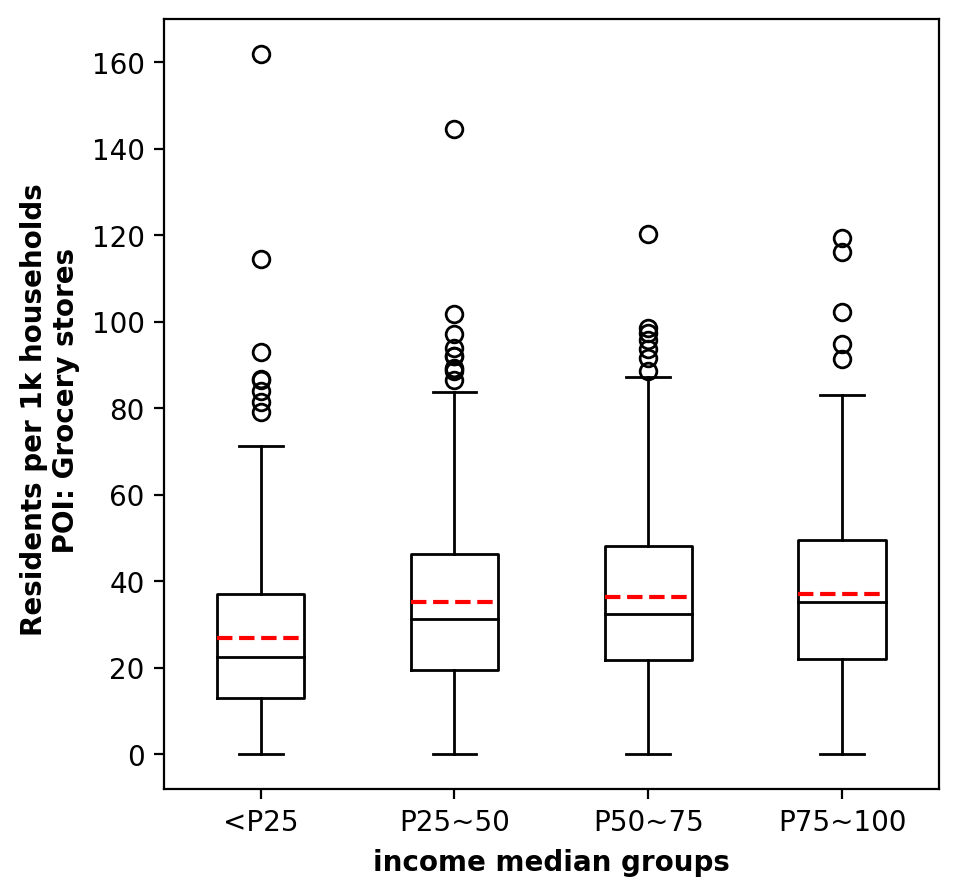

Basic statistics of each group
+---------+-----+---------+----------+---------+--------------------+
|         |  N  |   Min   |   Max    | Median  |      Variance      |
+---------+-----+---------+----------+---------+--------------------+
| Group 1 | 383 | 9910.0  | 40750.0  | 31910.0 | 46757931.65857859  |
| Group 2 | 382 | 40805.0 | 54464.0  | 47290.0 | 16894451.955201935 |
| Group 3 | 382 | 54554.0 | 70893.0  | 62040.5 | 21207877.27524014  |
| Group 4 | 383 | 70962.0 | 170278.0 | 86667.0 | 412770874.3385507  |
+---------+-----+---------+----------+---------+--------------------+
Boxplots of four groups


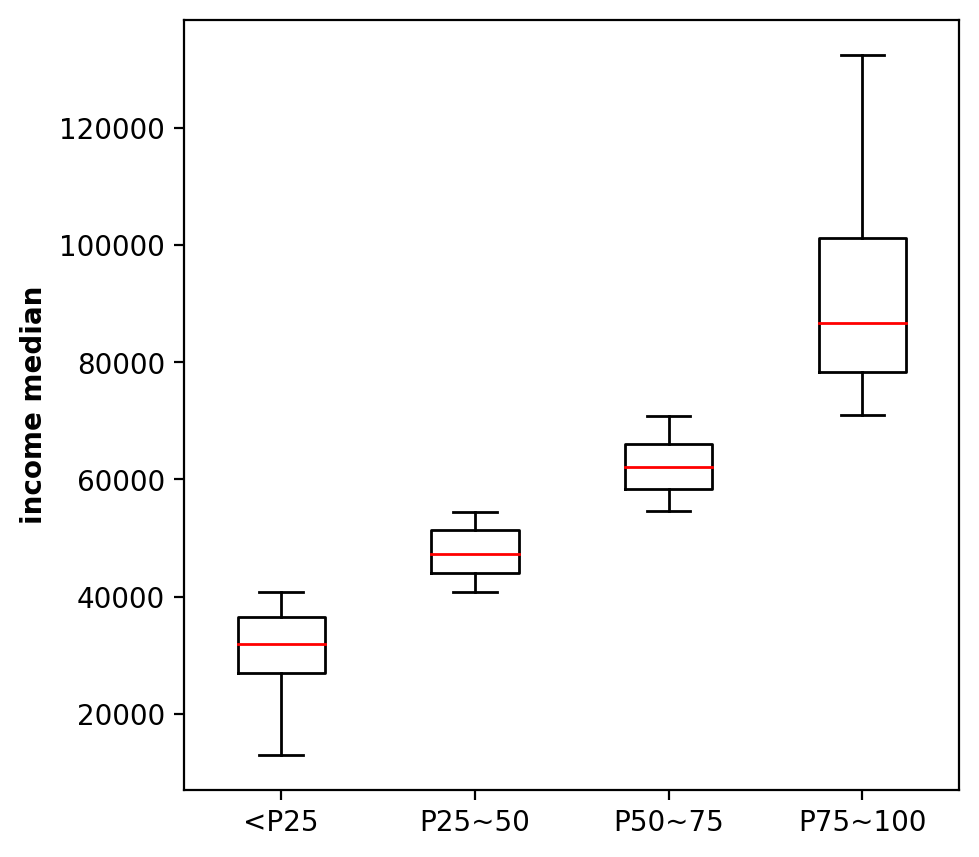

In [63]:
kw_test(df_before, 'income_median',True)

check the number of each group samples:
383 382 382 383


median of each quantile
23.543 32.215 34.45 35.176


Results of KW test
KruskalResult(statistic=58.33307825767246, pvalue=1.334421272700737e-12)


Results of Dunn test
              1             2             3             4
1  1.000000e+00  4.313353e-07  8.474193e-09  1.302765e-11
2  4.313353e-07  1.000000e+00  4.498417e-01  1.001758e-01
3  8.474193e-09  4.498417e-01  1.000000e+00  3.378015e-01
4  1.302765e-11  1.001758e-01  3.378015e-01  1.000000e+00


Boxplots of ratios of four groups


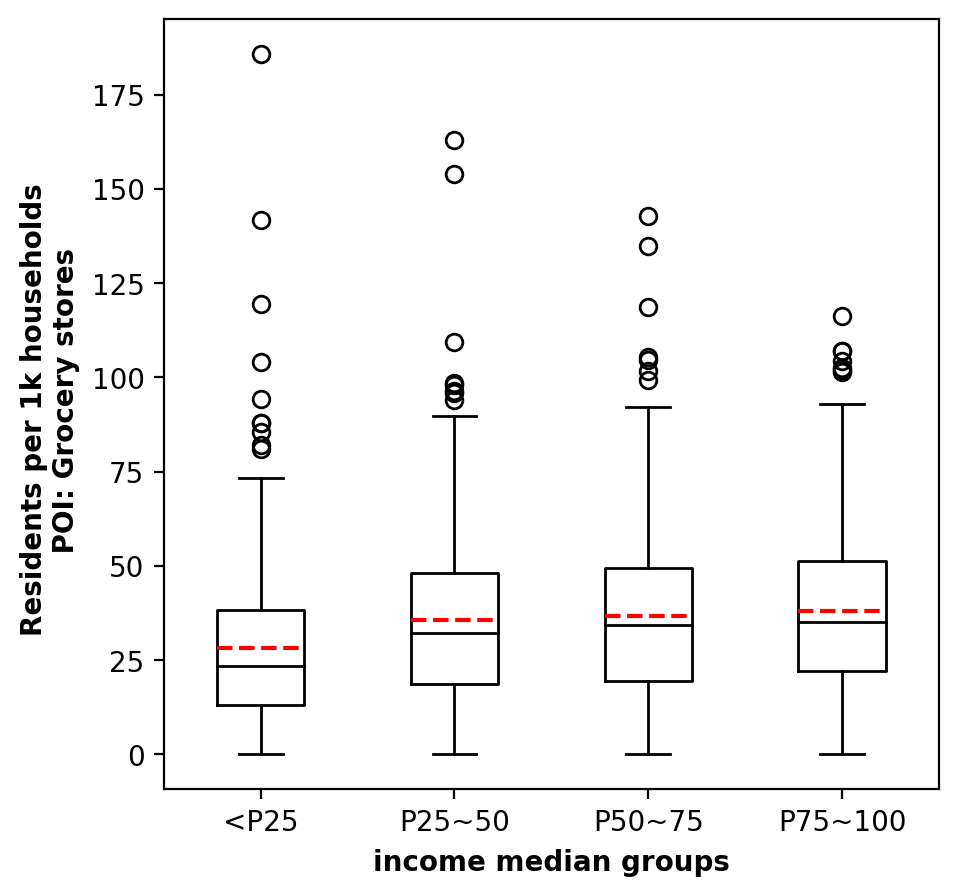

In [64]:
kw_test(df_08_23, 'income_median', False)

# Analysis based on PNAS paper methods

In [65]:
def Divide(dataframe):
    quantile1 = dataframe['income_median'].quantile(0.25)
    quantile2 = dataframe['income_median'].quantile(0.5)
    quantile3 = dataframe['income_median'].quantile(0.75)
    quantile4 = dataframe['income_median'].quantile(1)

    group1 = dataframe[(dataframe['income_median'] >= 0) & (dataframe['income_median'] < quantile1)]
    group2 = dataframe[(dataframe['income_median'] >= quantile1) & (dataframe['income_median'] < quantile2)]
    group3 = dataframe[(dataframe['income_median'] >= quantile2) & (dataframe['income_median'] < quantile3)]
    group4 = dataframe[(dataframe['income_median'] >= quantile3) & (dataframe['income_median'] <= quantile4)]
    
    return group1, group2, group3, group4

In [66]:
def Reg(dataframe):
    g_1, g_2, g_3, g_4 = Divide(dataframe)
    
    formula = ('visits_per_household ~ white_per_population') #rainfall_transfer remove this indepent variable
    
    model1 = sm.ols(formula = formula, data = g_1)
    result1 = model1.fit()
    print('Data sournce: P<25')
    print(result1.summary())
    print('\n')
    
    model2 = sm.ols(formula = formula, data = g_2)
    result2 = model2.fit()
    print('Data sournce: P25~50')
    print(result2.summary())
    print('\n')
    
    model3 = sm.ols(formula = formula, data = g_3)
    result3 = model3.fit()
    print('Data sournce: P50~75')
    print(result3.summary())
    print('\n')
    
    model4 = sm.ols(formula = formula, data = g_4)
    result4 = model4.fit()
    print('Data sournce: P75~100')
    print(result4.summary())
    print('\n')
    
    return None

In [69]:
df_income_race = Cor_analysis(build_new_08_23, de_0823)
df_income_race['white_per_population'] = df_income_race.White/df_income_race.Population

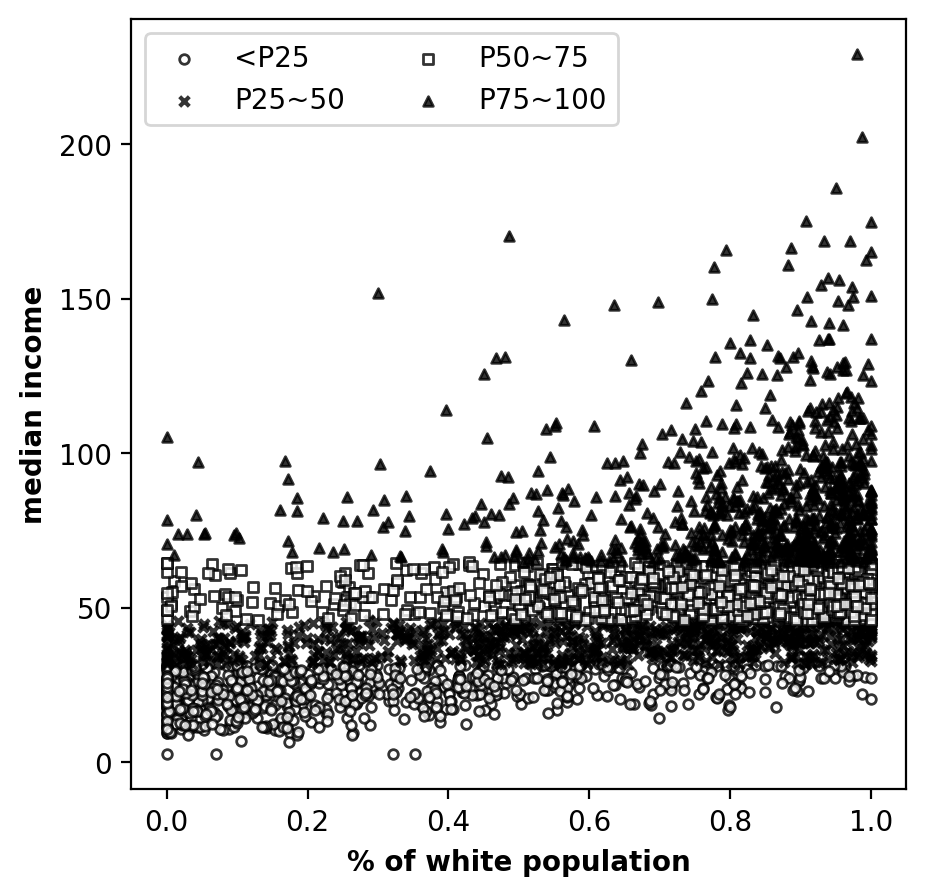

In [70]:
quantile1 = df_income_race['income_median'].quantile(0.25)
quantile2 = df_income_race['income_median'].quantile(0.5)
quantile3 = df_income_race['income_median'].quantile(0.75)
quantile4 = df_income_race['income_median'].quantile(1)

group1 = df_income_race[(df_income_race['income_median'] >= 0) & (df_income_race['income_median'] < quantile1)]
group2 = df_income_race[(df_income_race['income_median'] >= quantile1) & (df_income_race['income_median'] < quantile2)]
group3 = df_income_race[(df_income_race['income_median'] >= quantile2) & (df_income_race['income_median'] < quantile3)]
group4 = df_income_race[(df_income_race['income_median'] >= quantile3) & (df_income_race['income_median'] <= quantile4)]

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina', quality=100)

fig, ax = plt.subplots(figsize = (5,5))
plt.style.use('default') 
plt.rcParams.update({'figure.dpi':150})



plt.scatter(group1.white_per_population, group1.income_median/1000, 
            c='w', marker='o', alpha=0.8, s=12.0, label='<P25', edgecolors='black')
plt.scatter(group2.white_per_population, group2.income_median/1000, 
            c='black', marker='x', alpha=0.8, s=12.0, label='P25~50')
plt.scatter(group3.white_per_population, group3.income_median/1000, 
            c='w', marker='s', alpha=0.8, s=12.0, label='P50~75',edgecolors='black')
plt.scatter(group4.white_per_population, group4.income_median/1000, 
            c='black', marker='^', alpha=0.8, s=12.0, label='P75~100')

plt.legend(loc=2, ncol=2)

#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.xlabel( '% of white population', weight='bold')
plt.ylabel("median income", weight='bold')
plt.show()

In [71]:
spearmanr(df_income_race.white_per_population, df_income_race.income_median)

SpearmanrResult(correlation=0.596059657916263, pvalue=3.52899605455301e-309)

In [72]:
group1.white_per_population.median()

0.1852216748768473

In [73]:
group4.white_per_population.median()

0.8689731143060823

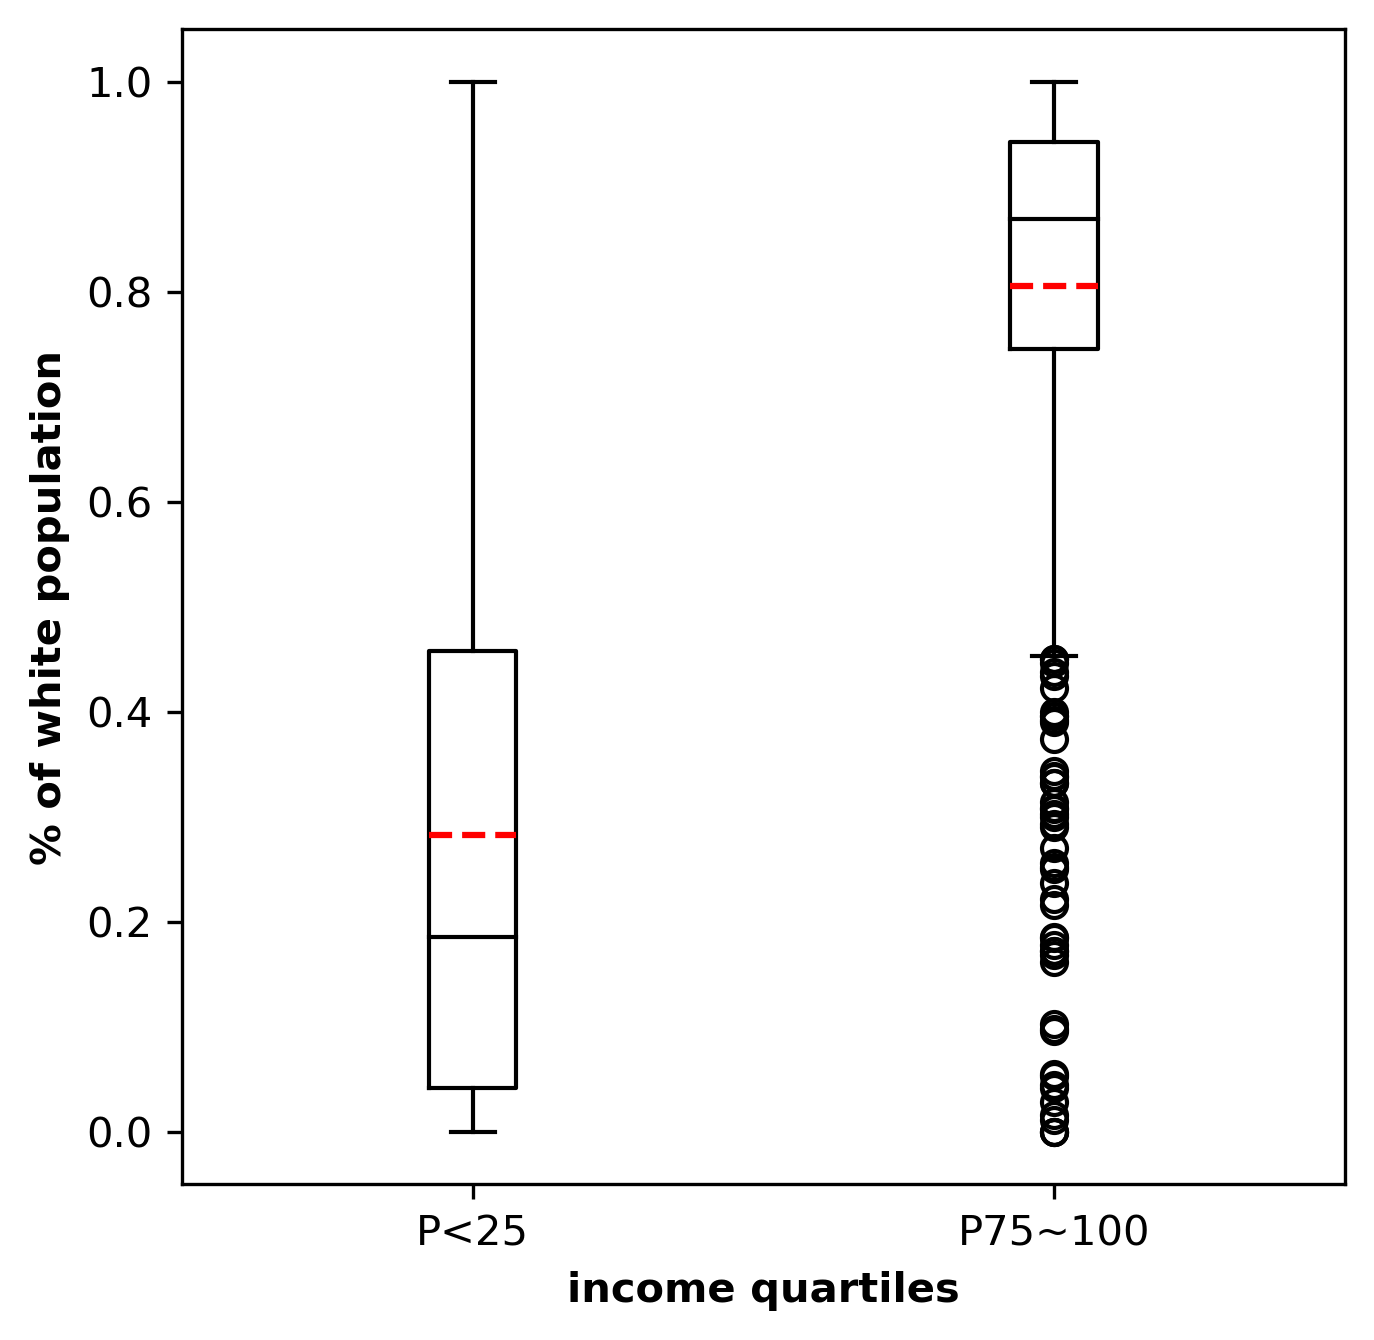

In [74]:
df_temp =  pd.concat(
        [
            group1.white_per_population.reset_index(drop=True).rename('P<25'),
            group4.white_per_population.reset_index(drop=True).rename('P75~100'),
        ], 
        axis=1)

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina', quality=100)

fig, ax = plt.subplots(figsize = (5,5))
plt.style.use('default')
plt.rcParams.update({'figure.dpi':150})

color = {
"boxes": "Black",
"whiskers": "Black",
"medians": "Black",
"caps": "Black"}

meanlineprops = dict(linestyle='--', linewidth=1.5, color='Red')
df_temp.boxplot(showfliers=True, grid=False, color=color, meanprops=meanlineprops, showmeans=True, meanline=True)


plt.xlabel('income quartiles', weight='bold')
plt.ylabel("% of white population", weight='bold')
plt.show()

# if we use filtered data

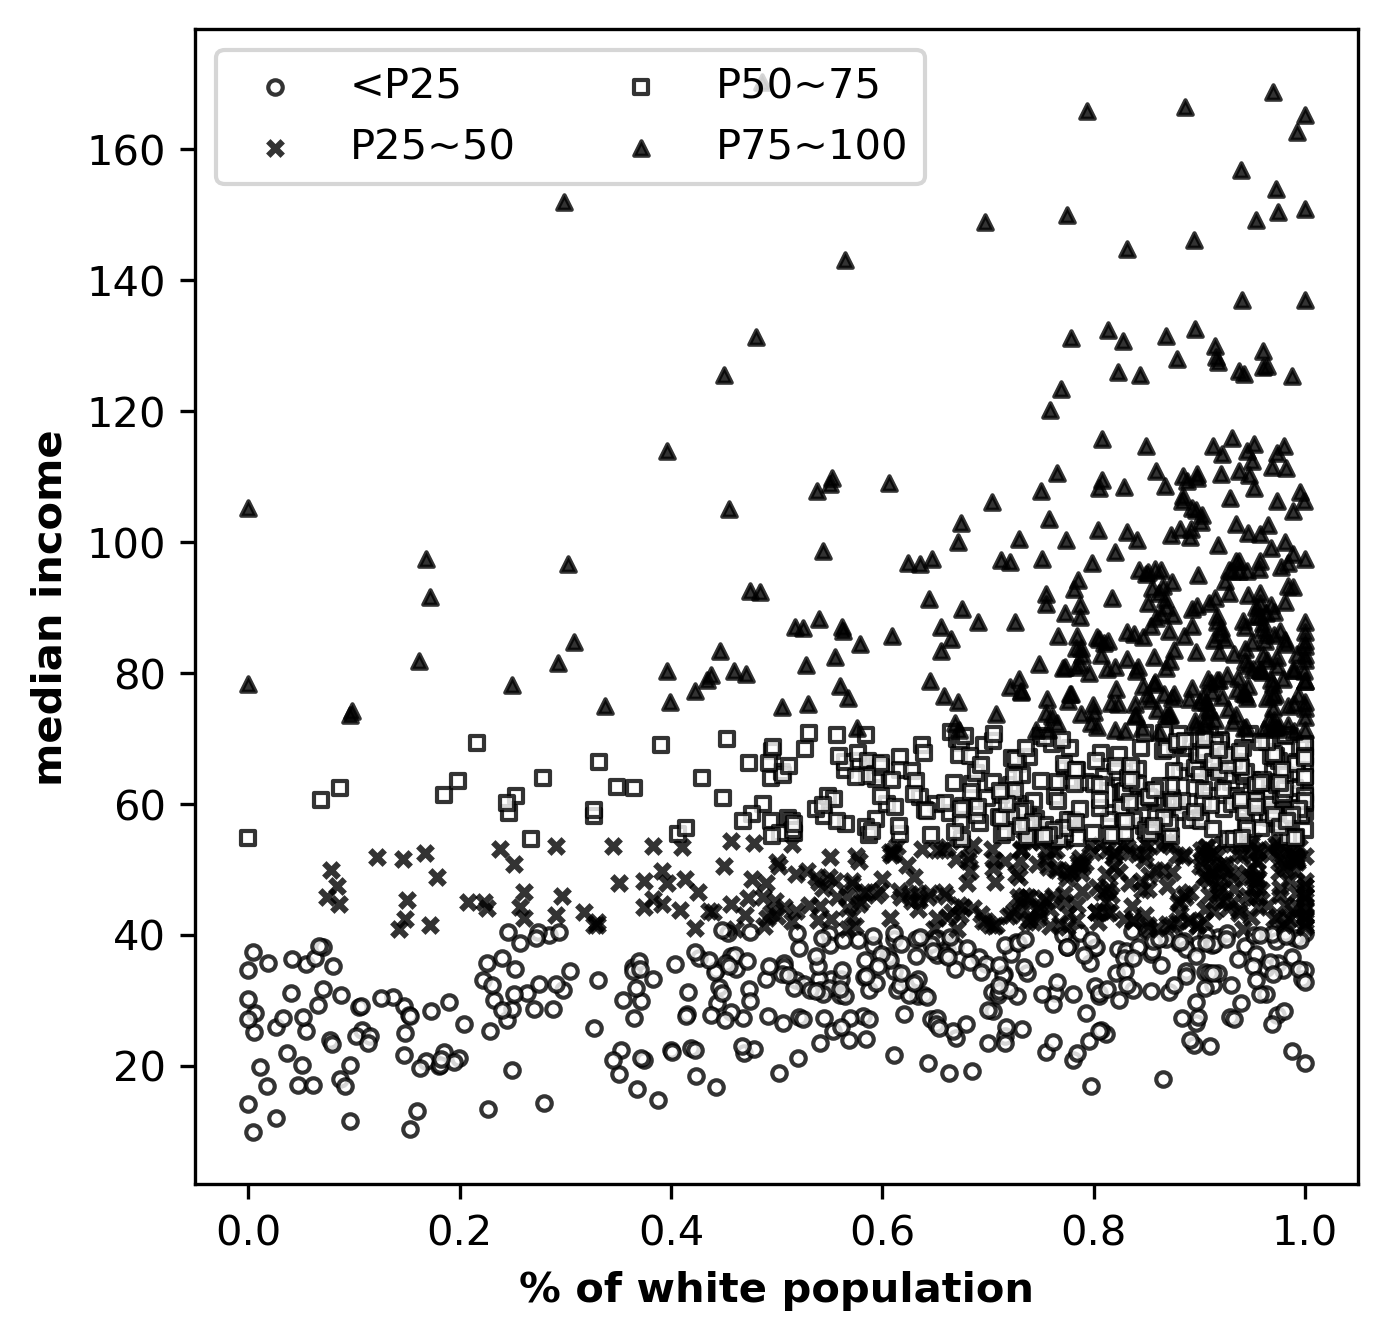

In [75]:
quantile1 = df_before['income_median'].quantile(0.25)
quantile2 = df_before['income_median'].quantile(0.5)
quantile3 = df_before['income_median'].quantile(0.75)
quantile4 = df_before['income_median'].quantile(1)

group1 = df_before[(df_before['income_median'] >= 0) & (df_before['income_median'] < quantile1)]
group2 = df_before[(df_before['income_median'] >= quantile1) & (df_before['income_median'] < quantile2)]
group3 = df_before[(df_before['income_median'] >= quantile2) & (df_before['income_median'] < quantile3)]
group4 = df_before[(df_before['income_median'] >= quantile3) & (df_before['income_median'] <= quantile4)]

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina', quality=100)

fig, ax = plt.subplots(figsize = (5,5))
plt.style.use('default') 
plt.rcParams.update({'figure.dpi':150})



plt.scatter(group1.white_per_population, group1.income_median/1000, 
            c='w', marker='o', alpha=0.8, s=12.0, label='<P25', edgecolors='black')
plt.scatter(group2.white_per_population, group2.income_median/1000, 
            c='black', marker='x', alpha=0.8, s=12.0, label='P25~50')
plt.scatter(group3.white_per_population, group3.income_median/1000, 
            c='w', marker='s', alpha=0.8, s=12.0, label='P50~75',edgecolors='black')
plt.scatter(group4.white_per_population, group4.income_median/1000, 
            c='black', marker='^', alpha=0.8, s=12.0, label='P75~100')

plt.legend(loc=2, ncol=2)

#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.xlabel( '% of white population', weight='bold')
plt.ylabel("median income", weight='bold')
plt.show()

In [76]:
spearmanr(df_before.white_per_population, df_before.income_median)

SpearmanrResult(correlation=0.3850747736992201, pvalue=2.9405674618749498e-55)

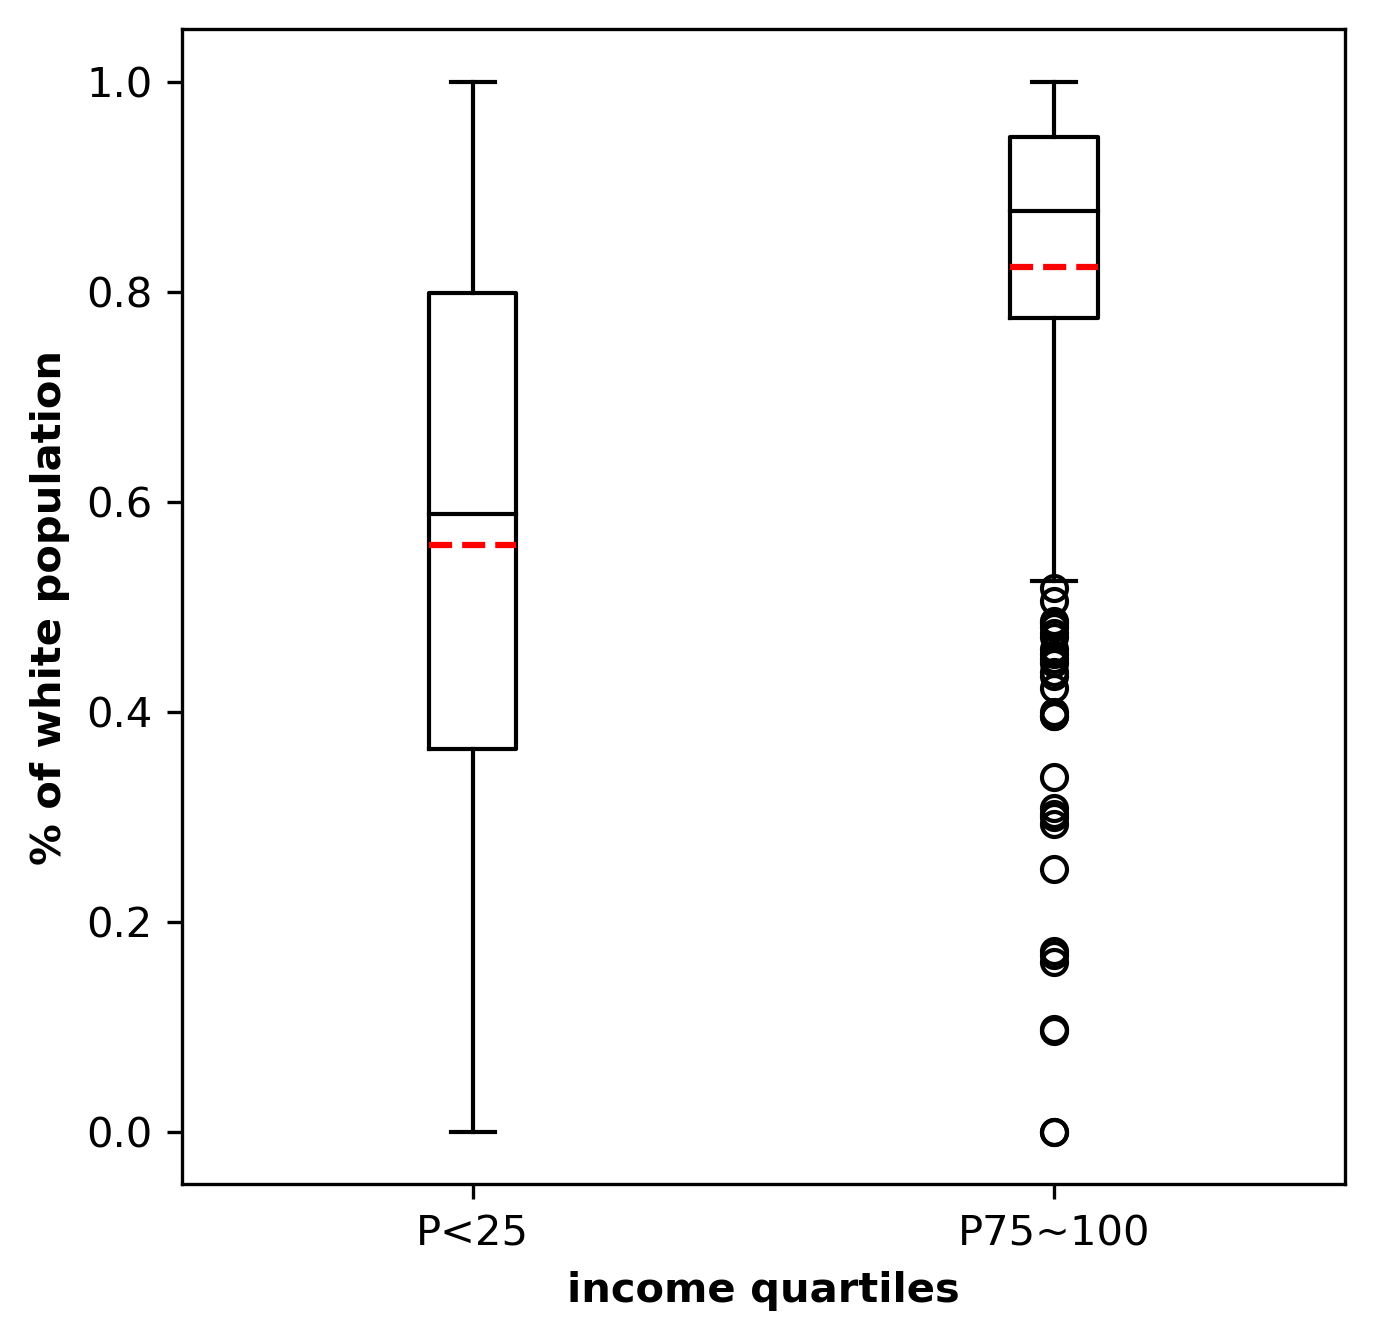

In [77]:
df_temp =  pd.concat(
        [
            group1.white_per_population.reset_index(drop=True).rename('P<25'),
            group4.white_per_population.reset_index(drop=True).rename('P75~100'),
        ], 
        axis=1)

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina', quality=100)

fig, ax = plt.subplots(figsize = (5,5))
plt.style.use('default')
plt.rcParams.update({'figure.dpi':150})

color = {
"boxes": "Black",
"whiskers": "Black",
"medians": "Black",
"caps": "Black"}

meanlineprops = dict(linestyle='--', linewidth=1.5, color='Red')
df_temp.boxplot(showfliers=True, grid=False, color=color, meanprops=meanlineprops, showmeans=True, meanline=True)


plt.xlabel('income quartiles', weight='bold')
plt.ylabel("% of white population", weight='bold')
plt.show()

In [78]:
group1.white_per_population.median()

0.5878220140515222

In [79]:
group4.white_per_population.median()

0.8764900662251656

# Results of regression in income strata

In [80]:
Reg(df_before)

Data sournce: P<25
                             OLS Regression Results                             
Dep. Variable:     visits_per_household   R-squared:                       0.266
Model:                              OLS   Adj. R-squared:                  0.264
Method:                   Least Squares   F-statistic:                     137.9
Date:                  Tue, 02 Aug 2022   Prob (F-statistic):           2.20e-27
Time:                          14:36:16   Log-Likelihood:                -1617.3
No. Observations:                   383   AIC:                             3239.
Df Residuals:                       381   BIC:                             3246.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [81]:
Reg(df_08_23)

Data sournce: P<25
                             OLS Regression Results                             
Dep. Variable:     visits_per_household   R-squared:                       0.211
Model:                              OLS   Adj. R-squared:                  0.209
Method:                   Least Squares   F-statistic:                     101.8
Date:                  Tue, 02 Aug 2022   Prob (F-statistic):           2.24e-21
Time:                          14:36:20   Log-Likelihood:                -1691.4
No. Observations:                   383   AIC:                             3387.
Df Residuals:                       381   BIC:                             3395.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

# p25 and p75 disparate ratio analysis

## income

In [82]:
def Divide_five(dataframe):
    quantile1 = dataframe['income_median'].quantile(0.25)
    quantile2 = dataframe['income_median'].quantile(0.5)
    quantile3 = dataframe['income_median'].quantile(0.75)
    quantile4 = dataframe['income_median'].quantile(1.0)
   

    group_25 = dataframe[(dataframe['income_median'] >= 0) & (dataframe['income_median'] < quantile1)]
    
    group_75 = dataframe[(dataframe['income_median'] >= quantile3) & (dataframe['income_median'] <= quantile4)]
    
    return group_25, group_75

In [83]:
P20_before, P80_before = Divide_five(df_before)

disparate_ratio_before = P80_before.visits_per_household.median()/P20_before.visits_per_household.median()

In [84]:
P20_before.income_median.median()

31910.0

In [85]:
P80_before.income_median.median()

86667.0

In [86]:
len(P20_before)

383

In [87]:
len(P80_before)

383

In [88]:
P20_before.visits_per_household.median()

22.465088038858532

In [89]:
P80_before.visits_per_household.median()

35.283194057567314

In [90]:
disparate_ratio_before

1.5705789354814423

In [91]:
import scipy.stats as stats
# perform two-sided test. You can use 'greater' or 'less' for one-sided test
stats.mannwhitneyu(x=P20_before['visits_per_household'], 
                   y=P80_before['visits_per_household'], 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=48952.0, pvalue=1.6385690813540891e-15)

In [92]:
P20_after, P80_after = Divide_five(df_08_23)

disparate_ratio_after= P80_after.visits_per_household.median()/P20_after.visits_per_household.median()

In [93]:
P80_after.visits_per_household.median()

35.175879396984925

In [94]:
P20_after.visits_per_household.median()

23.542600896860986

In [95]:
disparate_ratio_after

1.494137353433836

In [96]:
import scipy.stats as stats
# perform two-sided test. You can use 'greater' or 'less' for one-sided test
stats.mannwhitneyu(x=P20_after['visits_per_household'], 
                   y=P80_after['visits_per_household'], 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=51772.5, pvalue=1.8458572985169868e-12)

## race

### Before Ida

In [97]:
P25_before, P50_before, P75_before, P100_before = Divide(df_before)

In [98]:
len(P25_before)

383

In [99]:
def Divide_race(dataframe):
    quantile1 = dataframe['white_per_population'].quantile(0.25)
    quantile2 = dataframe['white_per_population'].quantile(0.5)
    quantile3 = dataframe['white_per_population'].quantile(0.75)
    quantile4 = dataframe['white_per_population'].quantile(1.0)
    #quantile5 = dataframe['white_per_population'].quantile(1.0)

    group_25 = dataframe[(dataframe['white_per_population'] >= 0) & (dataframe['white_per_population'] < quantile1)]
    
    group_75 = dataframe[(dataframe['white_per_population'] >= quantile3) & (dataframe['white_per_population'] <= quantile4)]
    
    return group_25, group_75

In [100]:
def disparate_ratio_in_income_strata(income_strata):
    race_20, race_80 = Divide_race(income_strata)
    disparate_ratio = race_80.visits_per_household.median()/race_20.visits_per_household.median()
    median_20 = race_20.visits_per_household.median()
    median_80 = race_80.visits_per_household.median()
    
    print('median visits of p20 white is', median_20)
    print('median visits of p80 white is', median_80)
    print('p80/p20 disparate ratio is: ', disparate_ratio)
    
    x=race_20['visits_per_household']
    y=race_80['visits_per_household']
    test_result = stats.mannwhitneyu(x, y, alternative = 'two-sided')
    
    print('median percentage of p20 white is', race_20.white_per_population.median())
    print('median percentage of p80 white is', race_80.white_per_population.median())
    print(test_result)
    return None

In [101]:
disparate_ratio_in_income_strata(P25_before)

median visits of p20 white is 11.779730228832118
median visits of p80 white is 39.971357275173055
p80/p20 disparate ratio is:  3.3932319754945652
median percentage of p20 white is 0.1526916090427562
median percentage of p80 white is 0.9059241666208189
MannwhitneyuResult(statistic=901.0, pvalue=6.126528355190487e-22)


In [102]:
disparate_ratio_in_income_strata(P50_before)

median visits of p20 white is 22.252474469050604
median visits of p80 white is 44.59933776086265
p80/p20 disparate ratio is:  2.004241722550574
median percentage of p20 white is 0.47157871550394914
median percentage of p80 white is 0.9686661574239533
MannwhitneyuResult(statistic=1396.0, pvalue=7.330032969376685e-17)


In [103]:
disparate_ratio_in_income_strata(P75_before)

median visits of p20 white is 23.605523679717443
median visits of p80 white is 44.51700275107065
p80/p20 disparate ratio is:  1.8858722795173979
median percentage of p20 white is 0.555546782174495
median percentage of p80 white is 0.9706184816225056
MannwhitneyuResult(statistic=1901.0, pvalue=2.0669073250042678e-12)


In [104]:
disparate_ratio_in_income_strata(P100_before)

median visits of p20 white is 26.821972529604984
median visits of p80 white is 36.99804250559284
p80/p20 disparate ratio is:  1.3793930504087994
median percentage of p20 white is 0.6170077133932556
median percentage of p80 white is 0.9733609114180966
MannwhitneyuResult(statistic=3432.0, pvalue=0.002263699847093851)


### Preparation

In [105]:
P25_after, P50_after, P75_after, P100_after = Divide(df_08_23)

In [106]:
disparate_ratio_in_income_strata(P25_after)

median visits of p20 white is 13.214036920933474
median visits of p80 white is 39.499687955065525
p80/p20 disparate ratio is:  2.989221854866375
median percentage of p20 white is 0.1526916090427562
median percentage of p80 white is 0.9059241666208189
MannwhitneyuResult(statistic=1295.5, pvalue=7.240535331972565e-18)


In [107]:
disparate_ratio_in_income_strata(P50_after)

median visits of p20 white is 25.2477351017497
median visits of p80 white is 42.33498678445997
p80/p20 disparate ratio is:  1.6767835456862863
median percentage of p20 white is 0.47157871550394914
median percentage of p80 white is 0.9686661574239533
MannwhitneyuResult(statistic=2288.5, pvalue=1.707615356766537e-09)


In [108]:
disparate_ratio_in_income_strata(P75_after)

median visits of p20 white is 23.571593800601434
median visits of p80 white is 41.56585148765992
p80/p20 disparate ratio is:  1.7633873992262399
median percentage of p20 white is 0.555546782174495
median percentage of p80 white is 0.9706184816225056
MannwhitneyuResult(statistic=2393.0, pvalue=8.805693572432996e-09)


In [109]:
disparate_ratio_in_income_strata(P100_after)

median visits of p20 white is 29.65530631824204
median visits of p80 white is 37.01571005644831
p80/p20 disparate ratio is:  1.2481985402281488
median percentage of p20 white is 0.6170077133932556
median percentage of p80 white is 0.9733609114180966
MannwhitneyuResult(statistic=3543.5, pvalue=0.005715505543607864)


# now we use ratio instead of difference

## income p75/p25

In [110]:
def disparate_ratio_in_income(dataframe):
    temp_20, temp_80 = Divide_five(dataframe)
    
    print('number cbgs in P25 income', len(temp_20))
    print('number cbgs in P75 income', len(temp_80))
    
    income_20 = temp_20.replace([np.inf, -np.inf], np.nan)
    income_80 = temp_80.replace([np.inf, -np.inf], np.nan)
    
    disparate_ratio = income_80.ratio.dropna().median()/income_20.dropna().ratio.median()
    median_20 = income_20.ratio.dropna().median()
    median_80 = income_80.ratio.dropna().median()
    
    print('median ratio of p25 income is', median_20)
    print('median ratio of p75 income is', median_80)
    print('p75/p25 disparate ratio is: ', disparate_ratio)
    
    x=income_20['ratio'].dropna()
    y=income_80['ratio'].dropna()
    test_result = stats.mannwhitneyu(x, y, alternative = 'two-sided')
    
    
    print('median income of p25 income is', income_20.income_median.median())
    print('median income of p75 income is', income_80.income_median.median())
    print(test_result)
    return None

In [111]:
disparate_ratio_in_income(df_ratio)

number cbgs in P25 income 383
number cbgs in P75 income 383
median ratio of p25 income is 1.0
median ratio of p75 income is 1.0327868852459017
p75/p25 disparate ratio is:  1.0327868852459017
median income of p25 income is 31910.0
median income of p75 income is 86667.0
MannwhitneyuResult(statistic=71125.0, pvalue=0.7698520666389419)


## race

### Ratio as preparation

In [112]:
P25_ratio, P50_ratio, P75_ratio, P100_ratio = Divide(df_ratio)

In [113]:
def Divide_race(dataframe):
    quantile1 = dataframe['white_per_population'].quantile(0.25)
    quantile2 = dataframe['white_per_population'].quantile(0.5)
    quantile3 = dataframe['white_per_population'].quantile(0.75)
    quantile4 = dataframe['white_per_population'].quantile(1.0)
  

    group_25 = dataframe[(dataframe['white_per_population'] >= 0) & (dataframe['white_per_population'] < quantile1)]
    
    group_75 = dataframe[(dataframe['white_per_population'] >= quantile3) & (dataframe['white_per_population'] <= quantile4)]
    
    return group_25, group_75

In [114]:
def disparate_ratio_in_income_strata(income_strata):
    
    race_20, race_80 = Divide_race(income_strata)
    
    #race_20 = temp_20.replace([np.inf, -np.inf], np.nan).dropna()
    #race_80 = temp_80.replace([np.inf, -np.inf], np.nan).dropna()
    
    #remove_outlier_20 = race_20.ratio[race_20.ratio.between(race_20.ratio.quantile(.01), 
                                                            #race_20.ratio.quantile(.99))]
    #remove_outlier_80 = race_80.ratio[race_80.ratio.between(race_80.ratio.quantile(.01), 
                                                            #race_80.ratio.quantile(.99))]
    
    disparate_ratio = race_80.ratio.median()/race_20.ratio.median()
    median_20 = race_20.ratio.median()
    median_80 = race_80.ratio.median()
    
    print('median ratio in p25 white is', median_20)
    print('median ratio in p75 white is', median_80)
    print('p75/p25 disparate ratio is: ', disparate_ratio)
    
    x=race_20.ratio.dropna()
    y=race_80.ratio.dropna()
    test_result = stats.mannwhitneyu(x, y, alternative = 'two-sided')
    
    #print('test p20 ratio and 1')
    #test_result1 = stats.mannwhitneyu(x, 1, alternative = 'greater')
    #print(test_result1)
    
    #print('test p80 ratio and 1')
    #test_result2 = stats.mannwhitneyu(y, 1, alternative = 'greater')
    #print(test_result2)
    
    print('median percentage of p25 white is', race_20.white_per_population.median())
    print('median percentage of p75 white is', race_80.white_per_population.median())
    print(test_result)
    return None

In [115]:
disparate_ratio_in_income_strata(P25_ratio)

median ratio in p25 white is 0.978409090909091
median ratio in p75 white is 1.0431354359925789
p75/p25 disparate ratio is:  1.0661546848704637
median percentage of p25 white is 0.1526916090427562
median percentage of p75 white is 0.9059241666208189
MannwhitneyuResult(statistic=4177.0, pvalue=0.37705046850399837)


In [116]:
disparate_ratio_in_income_strata(P50_ratio)

median ratio in p25 white is 1.0165289256198347
median ratio in p75 white is 0.9313668224299065
p75/p25 disparate ratio is:  0.9162226464554366
median percentage of p25 white is 0.47157871550394914
median percentage of p75 white is 0.9686661574239533
MannwhitneyuResult(statistic=5377.0, pvalue=0.03255744133167289)


In [117]:
disparate_ratio_in_income_strata(P75_ratio)

median ratio in p25 white is 0.96
median ratio in p75 white is 0.9801753717117805
p75/p25 disparate ratio is:  1.0210160121997713
median percentage of p25 white is 0.555546782174495
median percentage of p75 white is 0.9706184816225056
MannwhitneyuResult(statistic=4387.0, pvalue=0.6515525396984825)


In [118]:
disparate_ratio_in_income_strata(P100_ratio)

median ratio in p25 white is 1.037593984962406
median ratio in p75 white is 1.0135135135135134
p75/p25 disparate ratio is:  0.9767920094007049
median percentage of p25 white is 0.6170077133932556
median percentage of p75 white is 0.9733609114180966
MannwhitneyuResult(statistic=4820.5, pvalue=0.41717108321790697)


## regression ratio

In [119]:
def Reg_ratio(dataframe):
    #dataframe['rainfall_transfer'] = StandardScaler().fit_transform(dataframe[['rainfall_history']])
    temp = dataframe.replace([np.inf, -np.inf], np.nan)
    index = temp[temp.ratio == 15].index
    temp = temp.drop(index)
    g_1, g_2, g_3, g_4 = Divide(temp.dropna())
    
    formula = ('ratio ~ white_per_population')# rainfall_transfer remove this variable
    
    model1 = sm.ols(formula = formula, data = g_1)
    result1 = model1.fit()
    print('Data sournce: P<25')
    print(result1.summary())
    print('\n')
    
    model2 = sm.ols(formula = formula, data = g_2)
    result2 = model2.fit()
    print('Data sournce: P25~50')
    print(result2.summary())
    print('\n')
    
    model3 = sm.ols(formula = formula, data = g_3)
    result3 = model3.fit()
    print('Data sournce: P50~75')
    print(result3.summary())
    print('\n')
    
    model4 = sm.ols(formula = formula, data = g_4)
    result4 = model4.fit()
    print('Data sournce: P75~100')
    print(result4.summary())
    print('\n')
    
    return None

In [120]:
Reg_ratio(df_ratio)

Data sournce: P<25
                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.08269
Date:                Tue, 02 Aug 2022   Prob (F-statistic):              0.774
Time:                        14:38:16   Log-Likelihood:                -530.19
No. Observations:                 380   AIC:                             1064.
Df Residuals:                     378   BIC:                             1072.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept    

# 1

In [121]:
from scipy import stats
import scikit_posthocs as sp
def kw_test_ratio(dataframe, column, print_statistics=True):
    
    test_variable = 'ratio'
    
    dataframe = dataframe.replace([np.inf, -np.inf], np.nan).dropna()
    
    quantile1 = dataframe[column].quantile(0.25)
    quantile2 = dataframe[column].quantile(0.5)
    quantile3 = dataframe[column].quantile(0.75)
    quantile4 = dataframe[column].quantile(1)
    
    group1 = dataframe[(dataframe[column] >= 0) & (dataframe[column] < quantile1)]
    group2 = dataframe[(dataframe[column] >= quantile1) & (dataframe[column] < quantile2)]
    group3 = dataframe[(dataframe[column] >= quantile2) & (dataframe[column] < quantile3)]
    group4 = dataframe[(dataframe[column] >= quantile3) & (dataframe[column] <= quantile4)]
    
    table = [['N', 'Min', 'Max', 'Median', 'Variance'], 
             ['Group 1', len(group1), group1[column].min(), group1[column].max(), group1[column].median(), group1[column].var()],
             ['Group 2', len(group2), group2[column].min(), group2[column].max(), group2[column].median(), group2[column].var()],
             ['Group 3', len(group3), group3[column].min(), group3[column].max(), group3[column].median(), group3[column].var()],
             ['Group 4', len(group4), group4[column].min(), group4[column].max(), group4[column].median(), group4[column].var()]]
    
    print('check the number of each group samples:')
    print(len(group1), len(group2), len(group3), len(group4))
    
    print('\n')
    
    #remove outlier
    
    test1 = group1[test_variable]
    #test1 = test1[test1.between(test1.quantile(.01), test1.quantile(.99))]
    
    test2 = group2[test_variable]
    #test2 = test2[test2.between(test2.quantile(.01), test2.quantile(.99))]
    
    test3 = group3[test_variable]
    #test3 = test3[test3.between(test3.quantile(.01), test3.quantile(.99))]
    
    test4 = group4[test_variable]
    #test4 = test4[test4.between(test4.quantile(.01), test4.quantile(.99))]
    
    
    print('median of each quantile')
    print(round(test1.median(),3), 
          round(test2.median(),3), 
          round(test3.median(),3), 
          round(test4.median(),3))
    
    print('\n')
    
    print('Results of KW test')
    kw = stats.kruskal(test1, test2, test3, test4)
    print(kw)
    
    print('\n')
    
    print('Results of Dunn test')
    dunn = sp.posthoc_dunn([test1,test2,test3,test4],
                           p_adjust = 'fdr_bh')
    print(dunn)
    
    print('\n')
    
    print('Boxplots of ratios of four groups')
    df_temp =  pd.concat(
        [
            test1.reset_index(drop=True).rename('<P25'),
            test2.reset_index(drop=True).rename('P25~50'),
            test3.reset_index(drop=True).rename('P50~75'),
            test4.reset_index(drop=True).rename('P75~100'),
        ], 
        axis=1)
    
    import matplotlib_inline.backend_inline
    matplotlib_inline.backend_inline.set_matplotlib_formats('retina', quality=100)
    
    fig, ax = plt.subplots(figsize = (5,5))
    plt.style.use('default')
    
    color = {
    "boxes": "Black",
    "whiskers": "Black",
    "medians": "Black",
    "caps": "Black"}
    
    meanlineprops = dict(linestyle='--', linewidth=1.5, color='Red')
    df_temp.boxplot(showfliers=True, grid=False, color=color, meanprops=meanlineprops, showmeans=True, meanline=True)
    
    plt.xlabel(column.replace('_', ' ') + ' groups', weight='bold')
    plt.ylabel("Ratio \n POI: Gasoline stations", weight='bold')
    plt.show()
    
    if print_statistics:
        print('Basic statistics of each group')
        print(tabulate(table, headers='firstrow', tablefmt='pretty'))

        print('Boxplots of four groups')
        df_temp1 =  pd.concat(
            [
                group1[column].reset_index(drop=True).rename('<P25'),
                group2[column].reset_index(drop=True).rename('P25~50'),
                group3[column].reset_index(drop=True).rename('P50~75'),
                group4[column].reset_index(drop=True).rename('P75~100'),
            ], 
            axis=1)
        fig, ax = plt.subplots(figsize = (5,5))
        plt.style.use('default')

        color = {
        "boxes": "Black",
        "whiskers": "Black",
        "medians": "Red",
        "caps": "Black"}

        df_temp1.boxplot(showfliers=False, grid=False, color=color)

        plt.ylabel(column.replace('_', ' '), weight='bold')
        plt.show()
    
    
    return None
    

check the number of each group samples:
380 380 380 380


median of each quantile
1.0 1.0 1.0 1.032


Results of KW test
KruskalResult(statistic=1.6248268653505937, pvalue=0.6537736879626836)


Results of Dunn test
         1        2        3        4
1  1.00000  0.76408  0.76408  0.76408
2  0.76408  1.00000  0.76408  0.76408
3  0.76408  0.76408  1.00000  0.76408
4  0.76408  0.76408  0.76408  1.00000


Boxplots of ratios of four groups


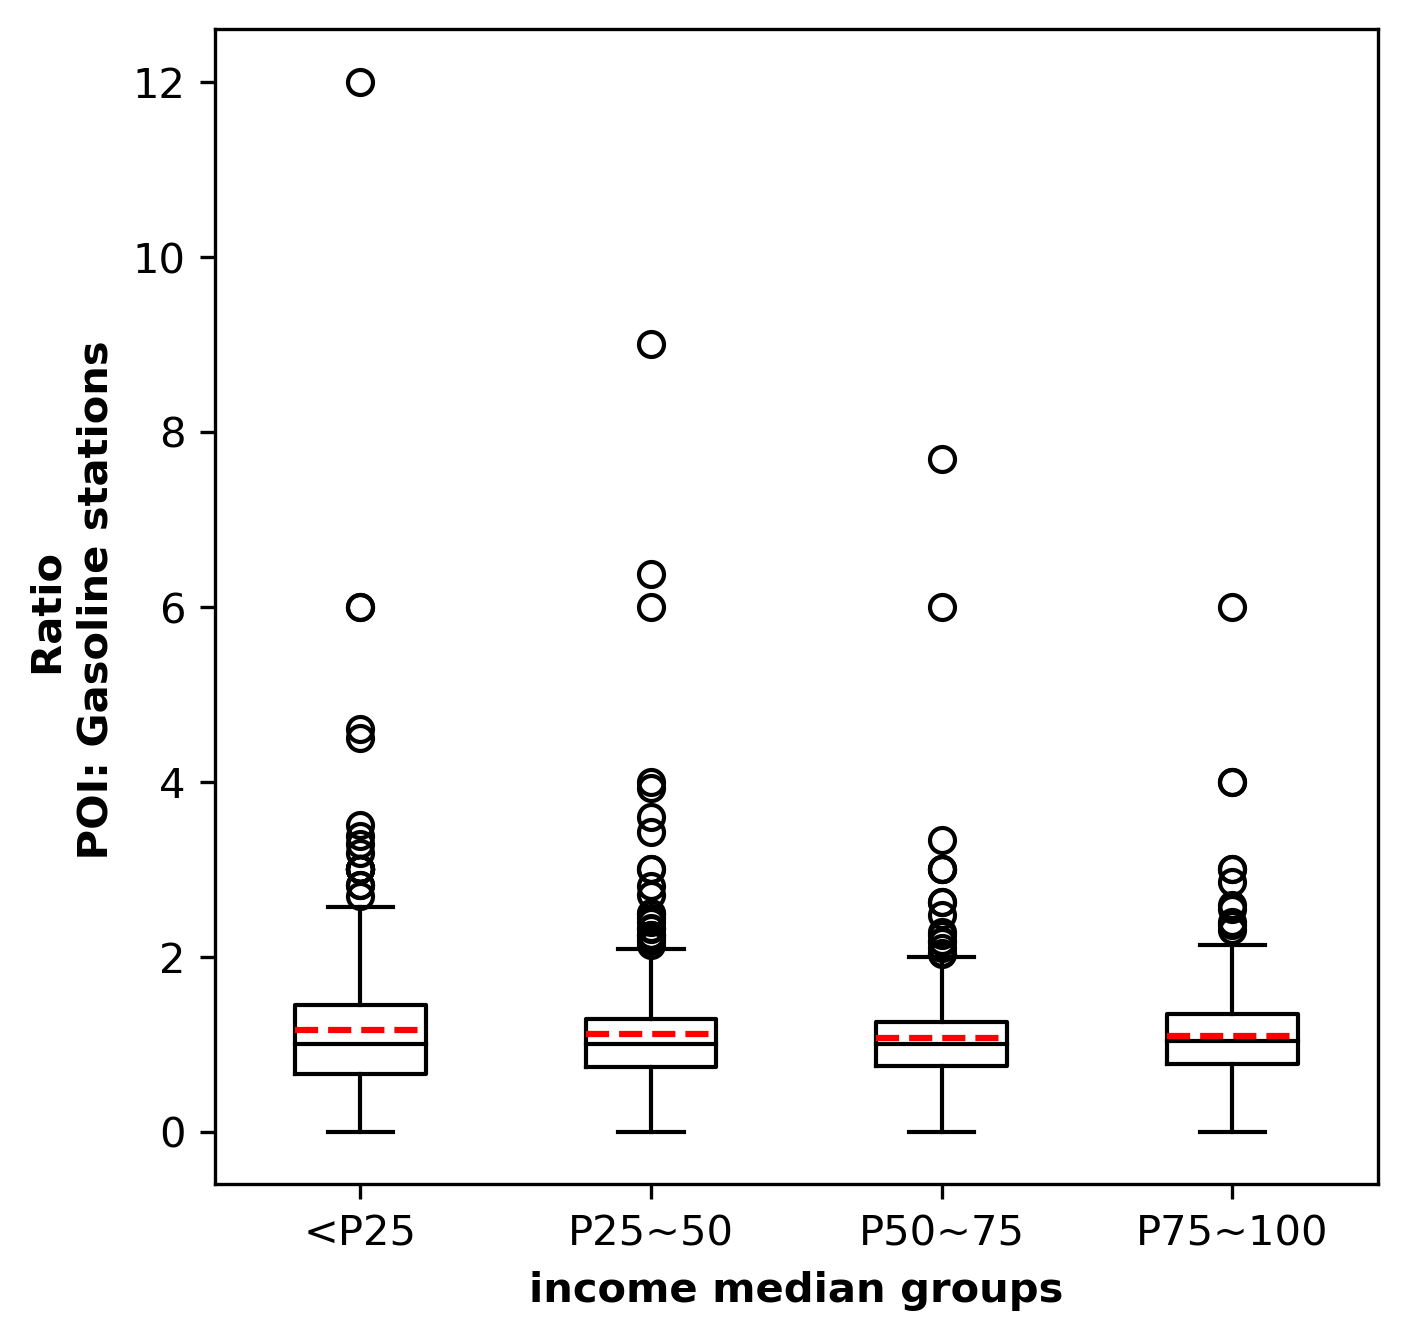

Basic statistics of each group
+---------+-----+---------+----------+---------+--------------------+
|         |  N  |   Min   |   Max    | Median  |      Variance      |
+---------+-----+---------+----------+---------+--------------------+
| Group 1 | 380 | 9910.0  | 40865.0  | 32239.5 | 46553613.96778225  |
| Group 2 | 380 | 40889.0 | 54554.0  | 47485.5 | 16846593.870184697 |
| Group 3 | 380 | 54604.0 | 70962.0  | 62110.5 | 21313643.436876822 |
| Group 4 | 380 | 71042.0 | 170278.0 | 86842.5 | 413533689.8589849  |
+---------+-----+---------+----------+---------+--------------------+
Boxplots of four groups


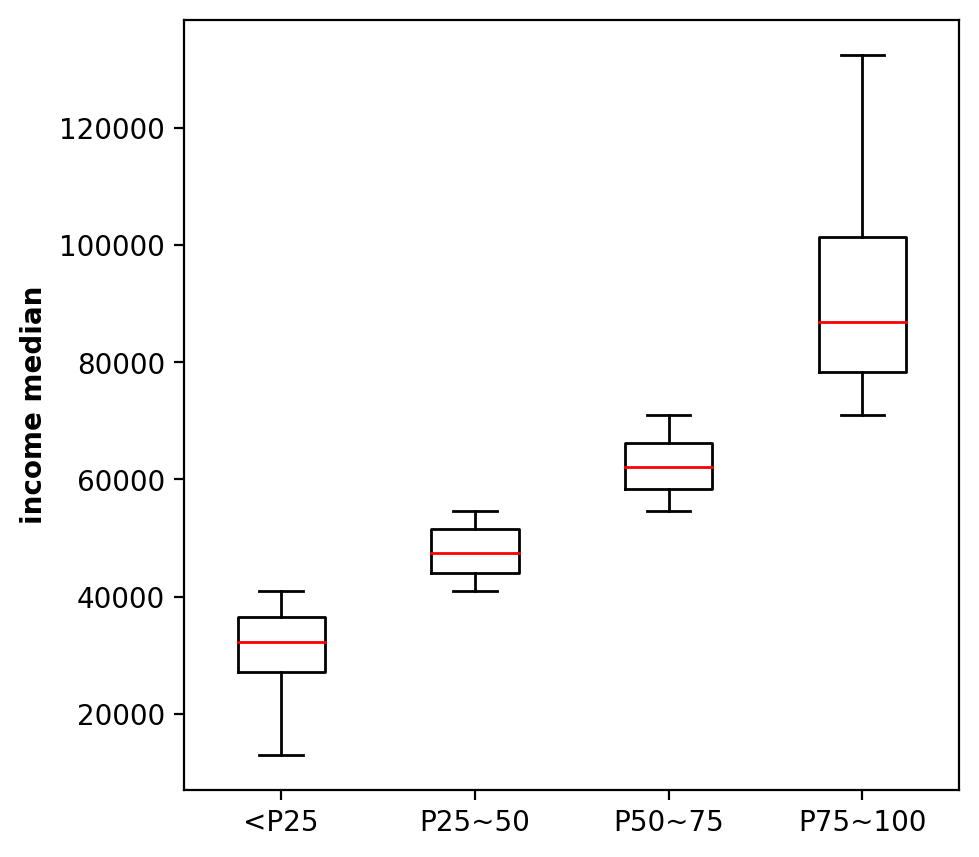

In [122]:
kw_test_ratio(df_ratio, 'income_median', print_statistics=True)

# number of device residing, population and number of households

In [94]:
from sklearn import linear_model

def Getline(xdata,ydata):
    X = np.array(xdata).reshape(-1,1)
    y = np.array(ydata).reshape(-1,1)
    reg_model = linear_model.LinearRegression()
    reg_model.fit(X,y)
    # Create the fited line
    a,b = reg_model.coef_, reg_model.intercept_
    index,amp = float(a),float(b)
    return [index,amp,reg_model.score(X,y)]

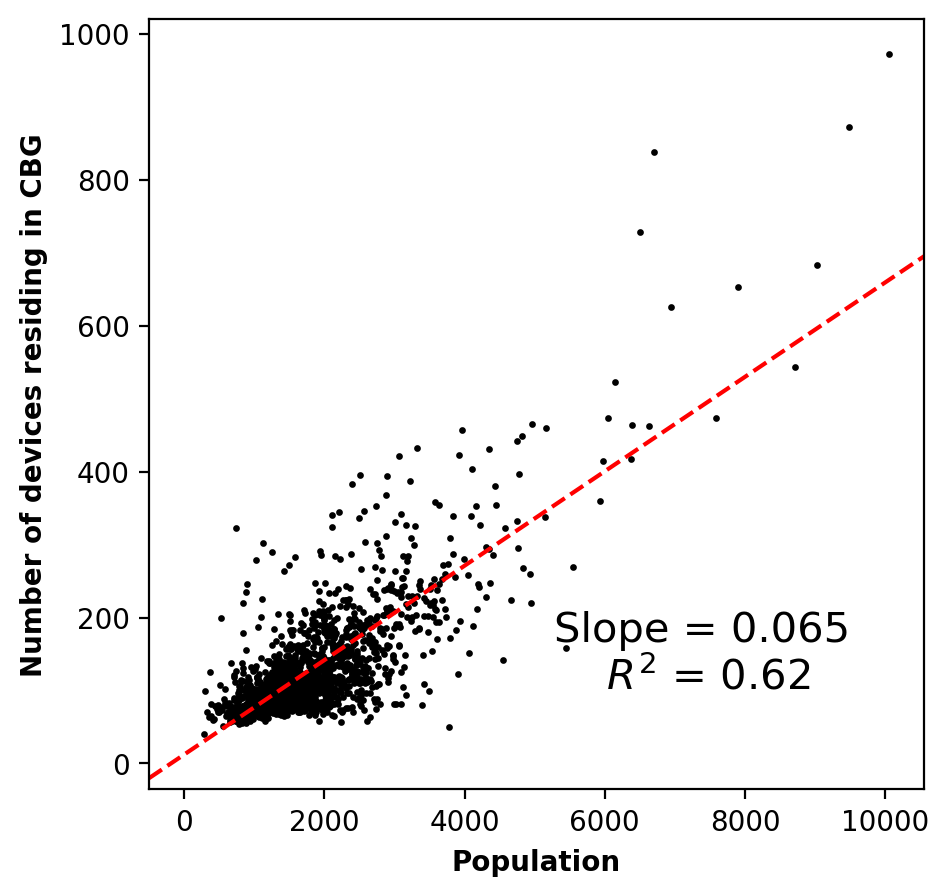

In [95]:
fig, ax = plt.subplots(figsize = (5,5))
plt.style.use('default')

x = df_before.Population
y = df_before.number_devices_residing

slope, intercept, r = Getline(x, y)

plt.scatter(x, y, s=2, c='black', alpha=1)
plt.axline((0, intercept), slope=slope, ls='--', c='Red', alpha=1)

#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

axes = plt.gca()
#print(axes.get_xlim())
#print(axes.get_ylim())
plt.text(x = 0.5*axes.get_xlim()[1],y = 0.1*axes.get_ylim()[1],s = 'Slope = %.3f\n    $R^2$ = %.2f'%(slope,r),fontsize = 15)

plt.xlabel("Population", weight='bold')
plt.ylabel("Number of devices residing in CBG", weight='bold')
#plt.title('Unique devices and total visits')
plt.show()

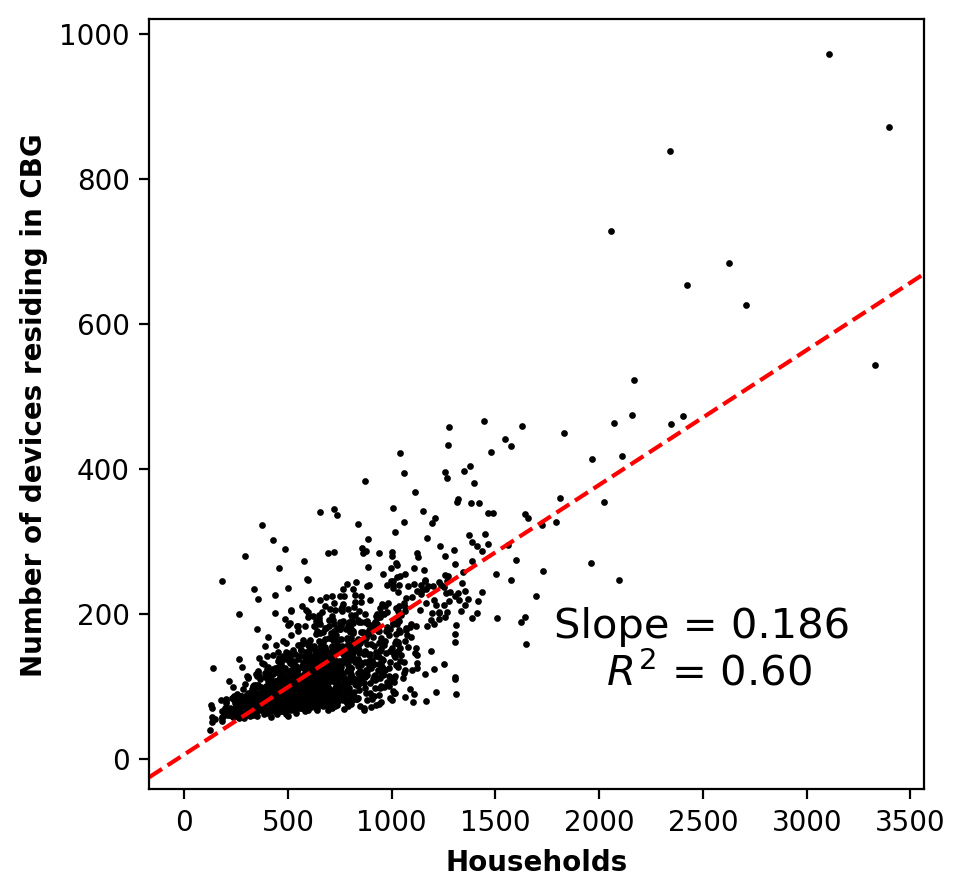

In [96]:
fig, ax = plt.subplots(figsize = (5,5))
plt.style.use('default')

x = df_before.households
y = df_before.number_devices_residing

slope, intercept, r = Getline(x, y)

plt.scatter(x, y, s=2, c='black', alpha=1)
plt.axline((0, intercept), slope=slope, ls='--', c='Red', alpha=1)

#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

axes = plt.gca()
#print(axes.get_xlim())
#print(axes.get_ylim())
plt.text(x = 0.5*axes.get_xlim()[1],y = 0.1*axes.get_ylim()[1],s = 'Slope = %.3f\n    $R^2$ = %.2f'%(slope,r),fontsize = 15)

plt.xlabel("Households", weight='bold')
plt.ylabel("Number of devices residing in CBG", weight='bold')
#plt.title('Unique devices and total visits')
plt.show()

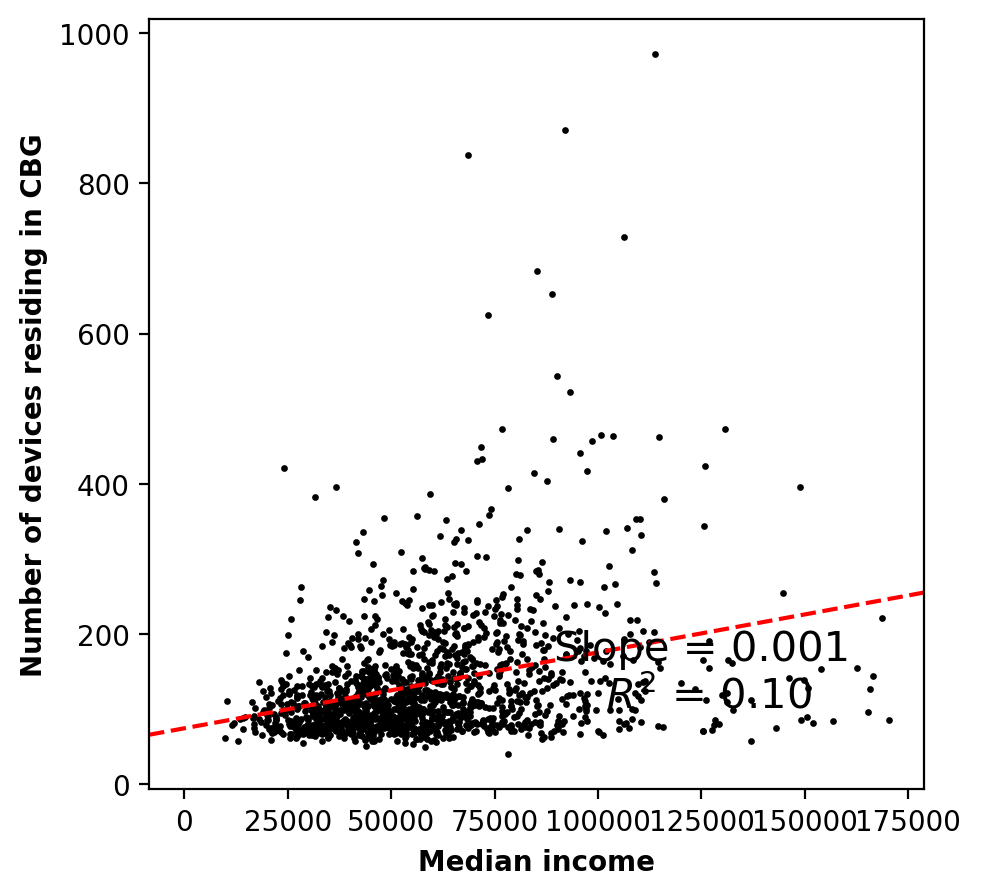

In [97]:
fig, ax = plt.subplots(figsize = (5,5))
plt.style.use('default')

x = df_before.income_median
y = df_before.number_devices_residing

slope, intercept, r = Getline(x, y)

plt.scatter(x, y, s=2, c='black', alpha=1)
plt.axline((0, intercept), slope=slope, ls='--', c='Red', alpha=1)

#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

axes = plt.gca()
#print(axes.get_xlim())
#print(axes.get_ylim())
plt.text(x = 0.5*axes.get_xlim()[1],y = 0.1*axes.get_ylim()[1],s = 'Slope = %.3f\n    $R^2$ = %.2f'%(slope,r),fontsize = 15)

plt.xlabel("Median income", weight='bold')
plt.ylabel("Number of devices residing in CBG", weight='bold')
#plt.title('Unique devices and total visits')
plt.show()

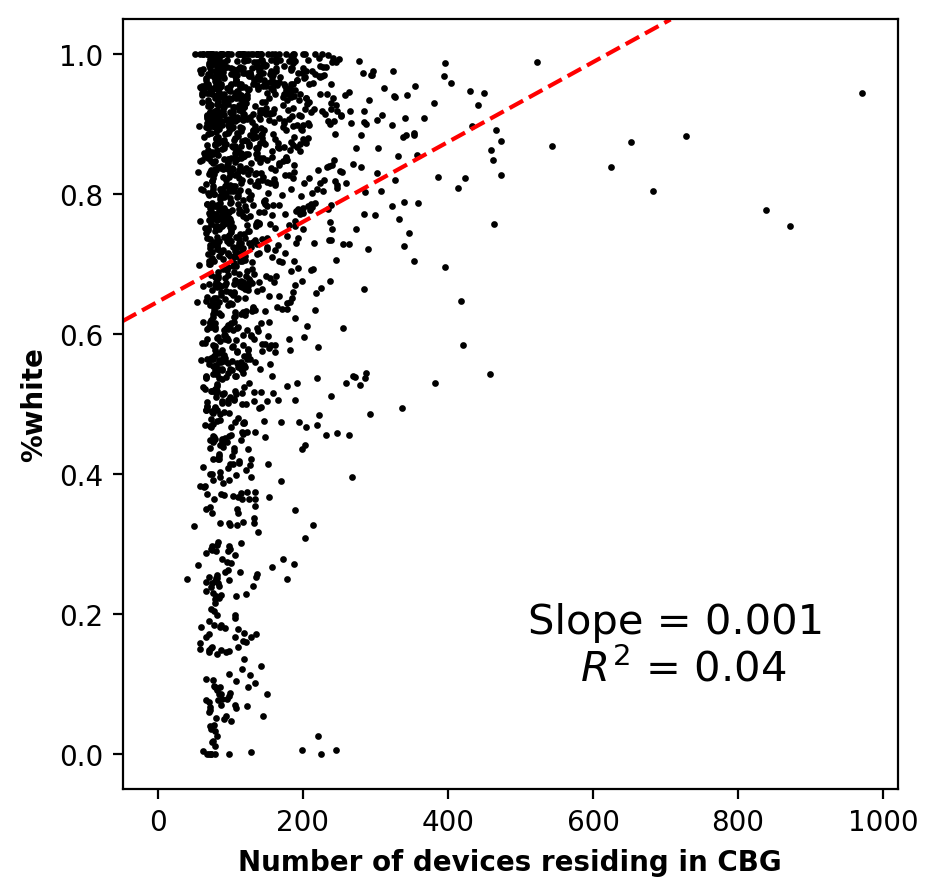

In [98]:
fig, ax = plt.subplots(figsize = (5,5))
plt.style.use('default')

y = df_before.white_per_population
x = df_before.number_devices_residing

slope, intercept, r = Getline(x, y)

plt.scatter(x, y, s=2, c='black', alpha=1)
plt.axline((0, intercept), slope=slope, ls='--', c='Red', alpha=1)

#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

axes = plt.gca()
#print(axes.get_xlim())
#print(axes.get_ylim())
plt.text(x = 0.5*axes.get_xlim()[1],y = 0.1*axes.get_ylim()[1],s = 'Slope = %.3f\n    $R^2$ = %.2f'%(slope,r),fontsize = 15)

plt.ylabel("%white", weight='bold')
plt.xlabel("Number of devices residing in CBG", weight='bold')
#plt.title('Unique devices and total visits')
plt.show()

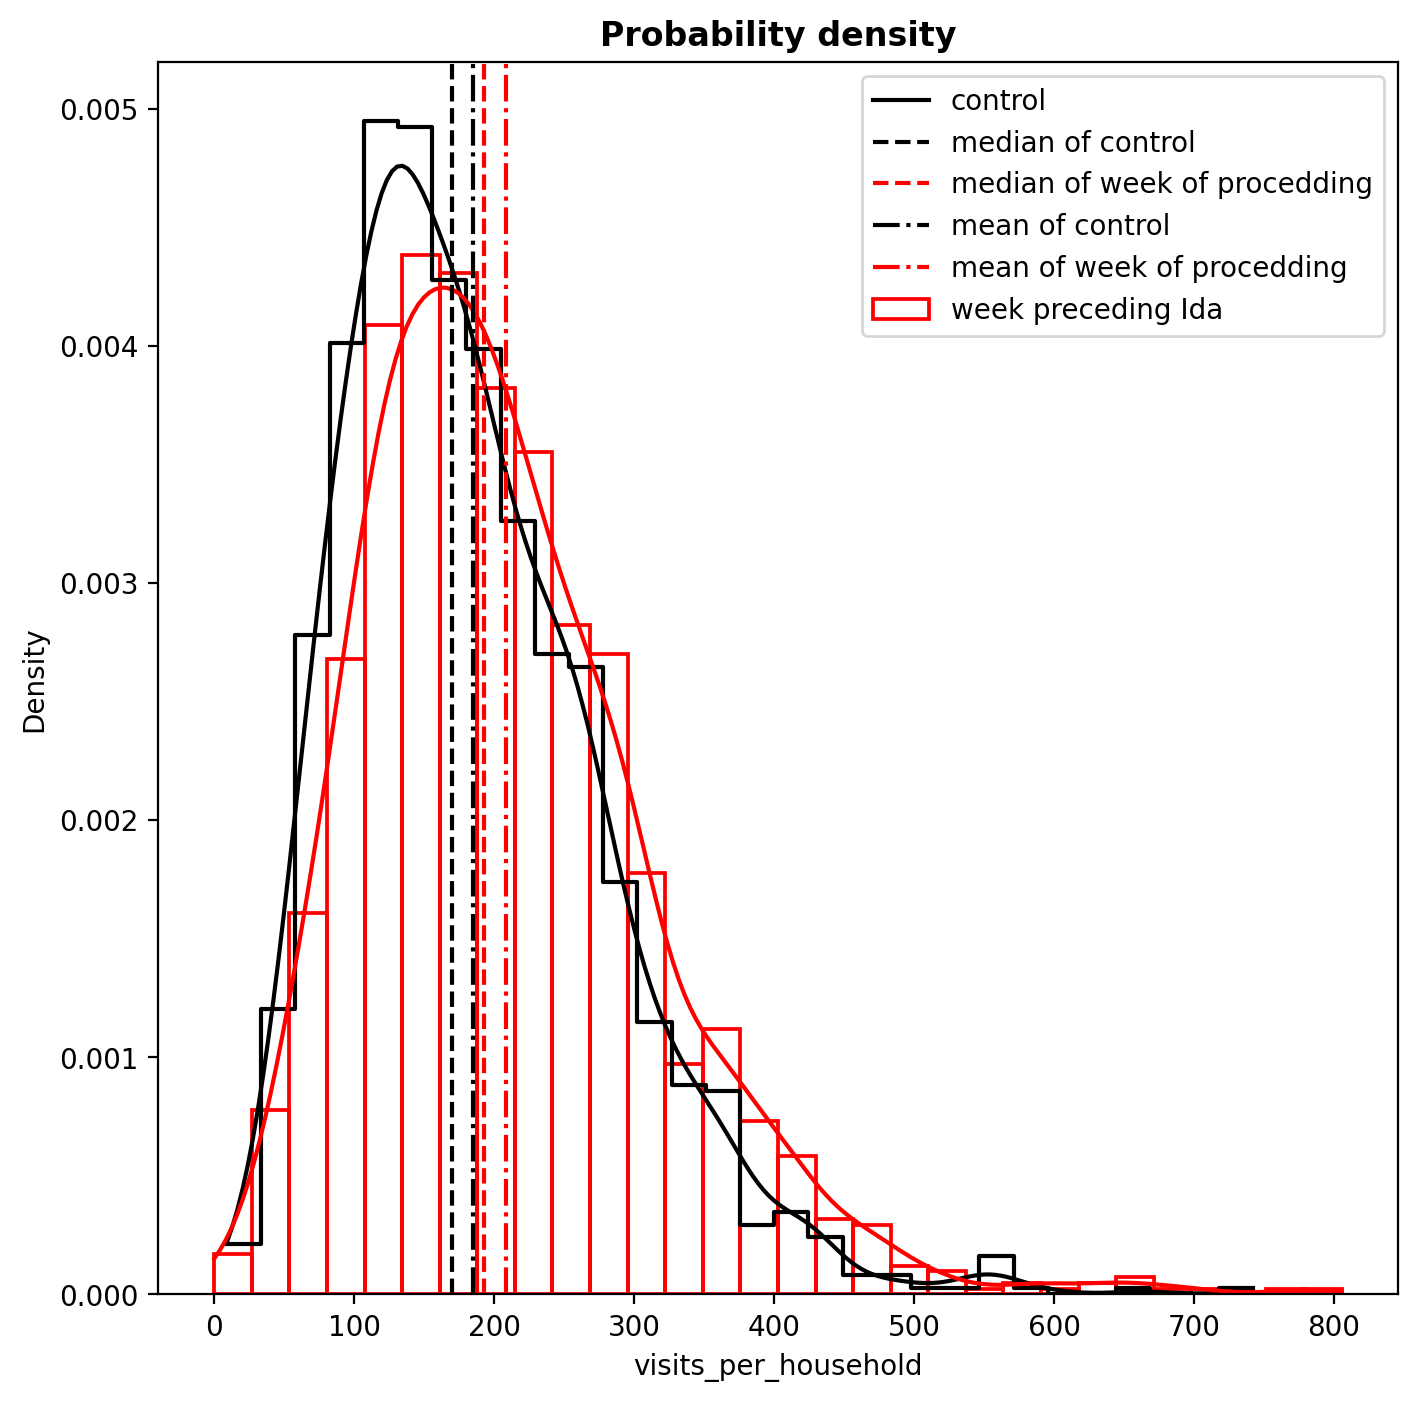

In [99]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (8,8))
plt.style.use('default')

data1 = df_before.visits_per_household
median1 = data1.median()
mean1 = data1.mean()

data2 = df_08_23.visits_per_household
median2 = data2.median()
mean2 = data2.mean()

sns.histplot(data1, label='control',bins=30, kde=True, color="black",
             fill=False, stat='density', element='step')
sns.histplot(data2, label='week preceding Ida', bins=30, kde=True, color="red", 
             fill=False, stat='density', multiple='stack')

plt.axvline(x = median1, linestyle='--',color = 'black', label = 'median of control')
plt.axvline(x = median2, linestyle='--',color = 'red', label = 'median of week of procedding')

plt.axvline(x = mean1, linestyle='-.',color = 'black', label = 'mean of control')
plt.axvline(x = mean2, linestyle='-.',color = 'red', label = 'mean of week of procedding')

plt.legend()
plt.title('Probability density', weight='bold')

plt.show()